In [1]:
import numpy as np
import xarray as xr
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import TwoSlopeNorm
import cmocean as cm
from scipy.optimize import fsolve

### 1D model

In [29]:
# Constants, data, parameters

rho = 1035 # kg/m^3
c = 4000 # J/(kg C)

z_m = 25.0 # Depth of minimum mixing layer
z_d = 900.0 # Depth for deep ocean restoring term
z_b = 1000.0 # Depth of thermocline

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
kappa = 5e-6
mu = 1/(5 * 365 * 86400)

T_0 = 22.0 # Top temperature for initial condition
T_b = 5.0 # Bottom temperature for initial condition (this warms up a bit during runs because of the no-flux at bottom condition)

decrease_dz_factor = 1
dt = decrease_dz_factor**2 * 10.0 * 86400 # units: s; decrease_dz_factor**2 in order to ensure numerical stability
dz = decrease_dz_factor * 5.0 # units: m

z = np.linspace(0.0, z_b, int(z_b / dz) + 1) # Depth at top/bottom of grid cell
z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell

# Initial condition: constant in mixing layer, linearly stratified elsewhere

def initial_condition(z_t):
    mixing_index = (np.abs(z_t - z_m)).argmin() # Index in z_t exactly dz / 2 m above z_m.
    mixing_layer = T_0 * np.ones(mixing_index + 1)
    z_t = z_t[mixing_index + 1:]
    thermocline = ((T_0 - T_b) * z_t - (T_0 * z_b - T_b * z_m)) / (z_m - z_b)
    return np.concatenate((mixing_layer, thermocline), axis = None)

T_i = initial_condition(z_t)

# Analytical steady state, cf. Appendix 1

def steady_state(Z):
    
    # Paramaters
    A = (1 + np.exp(2 * np.sqrt(mu / kappa) * (z_b - z_d))) * np.exp(np.sqrt(mu / kappa) * z_d)
    
    B = (T_0 - T_b) / (z_m - z_b) * (z_m - z_d - np.sqrt(kappa / mu) * np.exp(np.sqrt(mu / kappa) * (z_b - z_d)))
    
    C = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (z_d - z_m) \
    + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa))
    
    D = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    E = (T_0 - T_b) / (z_m - z_b) * (1 - np.exp((z_b - z_d) * np.sqrt(mu / kappa)))
    
    F = np.sqrt(mu / kappa) * (1 - np.exp(2 * (z_b - z_d) * np.sqrt(mu / kappa))) * np.exp(z_d * np.sqrt(mu / kappa))
    
    # Coefficients
    a_1 = (A * E + B * F) / (A * D - C * F)
    
    c_1 = (C * E + B * D) / (A * D - C * F)
    
    # Piecewise defined function (i.e., need to use vectorise):
    if Z <= z_m:
        
        return T_0 + a_1 * (np.exp(Z * np.sqrt(gamma / kappa)) + np.exp( - Z * np.sqrt(gamma / kappa)))
    
    elif Z > z_m and Z < z_d:
        
        return T_0 + a_1 * (np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (Z - z_m) \
                            + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    else:
        
        return ((T_0 - T_b) * Z + z_m * T_b - z_b * T_0) / (z_m - z_b) \
    + c_1 * (1 + np.exp(2 * (z_b - Z) * np.sqrt(mu / kappa))) * np.exp(Z * np.sqrt(mu / kappa)) \
    + np.sqrt(kappa / mu) * (T_0 - T_b) / (z_m - z_b) * np.exp((z_b - Z) * np.sqrt(mu / kappa))
    
v_ss = np.vectorize(steady_state)
steady = v_ss(z_t)


### Intermediate functions

def convective_adjustment(T, z_m):
        
    def mixing_Rahmstorf(T):
        
        for i in range(len(T) - 1):
            
            if T[i] < T[i + 1]:
                
                j = 0
                
                # This loop mixes the instability downwards
                
                while T[i + j] < T[i + j + 1]:
                    
                    T[i : i + j + 2] = np.mean(T[i : i + j + 2])
                    
                    j += 1
                    
                break
            
        return T
    
    
    # Run the Rahmstorf mixing algorithm until the instability has been eliminated from the water column (i.e., from the mixing layer) 
    
    for k in range(int(z_m / dz) + 1):
        
        mixing_Rahmstorf(T)
    
    return mixing_Rahmstorf(T)



### The forward-in-time, central-in-space scheme with restoring and flux boundary conditions ###

def model(dt, dz, z_m, z_d, z_b, kappa, lambd, T_initial, Q, T0, years):
    
    # Data
    days = dt / 86400 # Timestep in days
    M = int(z_b / dz) # Number of spatial steps evaluated at the top / bottom of the grid cell
    N = int(years * 360 / days) # Number of timesteps in days (taking for simplicity 1 year = 360 days)
    z = np.linspace(0.0, z_b, M + 1) # Depth at top / bottom of grid cell
    z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell 
    t = np.linspace(0.0, years * 360, N + 1)
    Hdeep = np.heaviside(z - z_d, 1) # 1 below z = z_d, 0 elsewhere
    Hmix = np.heaviside(z_m - z, 0) # 1 above z = z_m, 0 elsewhere
    radiative_forcing = Q / (c * rho * z_m)
    
    # Temperature and flux matrices. Prescribe initial and boundary conditions
    T = np.zeros((M, N + 1)) # i.e., evaluated at the middle of grid cell
    F = np.zeros((M + 1, N + 1)) # i.e., evaluated at the top / bottom of grid cell
    
    T[:, 0] = T_initial # Initial condition
    F[0, :] = 0 # No flux at surface
    F[- 1, :] = 0 # No flux at base
        
    for n in range(0, N):
    
        for m in range(1, M):
            
            F[m, n] = kappa / dz * (T[m - 1, n] - T[m, n])
            
        for m in range(0, M):
             
            #NB: T_i = T_i(z), the initial profile
            
            T[m, n + 1] = T[m, n] + dt / dz * (F[m, n] - F[m + 1, n]) \
            + dt * (radiative_forcing[n] - gamma * (T[m, n] - (T0[n] + T_i[m]))) * Hmix[m]  \
            - dt * mu * (T[m, n] - T_i[m]) * Hdeep[m]

        #Convective adjustment step
    
        convective_adjustment(T[:, n + 1], z_m)
        
    return T


### Ocean heat content

def OHC(T):
    
    OHC = np.empty(T.shape[1])
    
    for i in range(len(OHC)):
        
        ACCESS_ave_depth = 3642
        
        OHC[i] = z_b / ACCESS_ave_depth * np.mean(T[:, i]) # This is for average temperature
        
    return OHC

### Set length of experiment

years = 170
days = dt / 86400
M = int(z_b / dz)
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

### Define volcanic-style forcing time series

def normal(t, mu_year, sigma_year):
    mu = mu_year * 360
    sigma = sigma_year * 360
    return 1 / (np.sqrt(2 * np.pi * sigma**2)) * np.exp(- ((t - mu)/(sigma)) ** 2)

T0_volc_var = (-2000*normal(t, 32, 1.5) \
                        - 1000*normal(t, 55, 1.5) \
                        - 300*normal(t, 70, 1.) \
                        - 1200*normal(t, 110, 1.5) \
                        - 500*normal(t, 130, 1.0) \
                        - 2000*normal(t, 140, 1.5))
Q_volc_var = 8 * T0_volc_var


### Solving numerically for mu

def eqn(mu, kappa):
    # Paramaters
    A = (1 + np.exp(2 * np.sqrt(mu / kappa) * (z_b - z_d))) * np.exp(np.sqrt(mu / kappa) * z_d)
    
    B = (T_0 - T_b) / (z_m - z_b) * (z_m - z_d - np.sqrt(kappa / mu) * np.exp(np.sqrt(mu / kappa) * (z_b - z_d)))
    
    C = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (z_d - z_m) \
    + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa))
    
    D = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    E = (T_0 - T_b) / (z_m - z_b) * (1 - np.exp((z_b - z_d) * np.sqrt(mu / kappa)))
    
    F = np.sqrt(mu / kappa) * (1 - np.exp(2 * (z_b - z_d) * np.sqrt(mu / kappa))) * np.exp(z_d * np.sqrt(mu / kappa))
    
    # C_1
    c_1 = (C * E + B * D) / (A * D - C * F)
    
    # The equation
    T_b_final = T_b + 0.5
    
    equation = T_b_final - T_b - 2 * np.exp(np.sqrt(mu / kappa) * z_b) * c_1 - np.sqrt(kappa / mu) * (T_0 - T_b) / (z_m - z_b)
    
    return equation 

In [30]:
### Run volcanic experiments for different kappas ###

kappas = np.array([1e-6, 5e-6, 1e-5, 5e-5, 1e-4])

# N.B.: For the larger diffusivities to remain numerically stable, need to decrease dt to ensure the Von Neumann stability criterion

spin_up = 100
years = 170

OHC_volc_var_cont_kappas = []
OHC_volc_var_cst_kappas = []

# Intermediate run model function to be used for each diffusivity-dt combo

def run_volcanos_kappa(dt, kappa):
    # Calculate deep restoring given kappa and no more than 0.5C drift
    mu_initial_guess = 1 / (5 * 365 * 86400) # 1 / 5 years^-1
    mu_numerical_soln = fsolve(eqn, mu_initial_guess, kappa)
    mu = mu_numerical_soln[0]
    
    # Steady state given diffusivity
    v_ss = np.vectorize(steady_state)
    steady = v_ss(z_t)
        
    # Set length of experiment
    days = dt / 86400
    t_spinup = np.linspace(0.0, spin_up * 360, int(spin_up * 360 / days) + 1) # Spin-up period for time-mean volcanic forcing
    t = np.linspace(0.0, years * 360, int(years * 360 / days) + 1) # Experiment period
        
    # Define forcing time series
    T0_cont = np.full_like(t, 0)
    Q_cont = np.full_like(t, 0) 
    
    volcanic_factor = 1 # To scale the 5 x volcanic forcing, e.g., 0.2 --> 1 x volcanic forcing
    
    T0_volc_var = volcanic_factor * (-2000*normal(t, 32, 1.5) \
                        - 1000*normal(t, 55, 1.5) \
                        - 300*normal(t, 70, 1.) \
                        - 1200*normal(t, 110, 1.5) \
                        - 500*normal(t, 130, 1.0) \
                        - 2000*normal(t, 140, 1.5))
    Q_volc_var = 8 * T0_volc_var
        
    T0_volc_cst_spinup = np.mean(T0_volc_var) * np.full_like(t_spinup, 1) 
    Q_volc_cst_spinup = np.mean(Q_volc_var) * np.full_like(t_spinup, 1) 
        
    T0_volc_cst_cont = np.mean(T0_volc_var) * np.full_like(t, 1)
    Q_volc_cst_cont = np.mean(Q_volc_var) * np.full_like(t, 1) 
        
    ### Run experiments ###
    T_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_cont, T0_cont, years) # control (no forcing)

    T_volc_var = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_volc_var, T0_volc_var, years) # volc_var (variable volcanic forcing)
    
    T_volc_cst_spinup = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_volc_cst_spinup, T0_volc_cst_spinup, spin_up) # volc_cst (constant volcanic forcing equal to time-mean of variable volcanic forcing), 500 year spin-up

    T_volc_cst_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_volc_cst_spinup[:, - 1], Q_volc_cst_cont, T0_volc_cst_cont, years) # as above but using the spun-up period as the initial state to then use like a piControl
    
    T_volc_var_cst_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_volc_cst_spinup[:, - 1], Q_volc_var, T0_volc_var, years) # initial condition is the state spun-up to the time-mean of the variable forcing which will then be presvribed
            
    # Make into xarray dataarrays
    OHC_volc_var_cont = xr.DataArray(data=OHC(T_volc_var - T_cont), coords=dict(time = t / 360 + 1850))
    OHC_volc_var_cst = xr.DataArray(data=OHC(T_volc_var_cst_cont - T_volc_cst_cont), coords=dict(time = t / 360 + 1850))
    
    return OHC_volc_var_cont, OHC_volc_var_cst
    

# Do the loop:

for k in range(len(kappas)):
    kappa = kappas[k]
    if kappa <= 1e-5:
        dt = decrease_dz_factor**2 * 10.0 * 86400
        OHC_volc_var_cont, OHC_volc_var_cst = run_volcanos_kappa(dt, kappa)
        
        OHC_volc_var_cont_kappas.append(OHC_volc_var_cont)
        OHC_volc_var_cst_kappas.append(OHC_volc_var_cst)

    elif kappa <= 2e-5:
        dt = decrease_dz_factor**2 * 5.0 * 86400
        OHC_volc_var_cont, OHC_volc_var_cst = run_volcanos_kappa(dt, kappa)
        
        OHC_volc_var_cont_kappas.append(OHC_volc_var_cont)
        OHC_volc_var_cst_kappas.append(OHC_volc_var_cst)
        
    elif kappa <= 5e-5:
        dt = decrease_dz_factor**2 * 2.0 * 86400
        OHC_volc_var_cont, OHC_volc_var_cst = run_volcanos_kappa(dt, kappa)
        
        OHC_volc_var_cont_kappas.append(OHC_volc_var_cont)
        OHC_volc_var_cst_kappas.append(OHC_volc_var_cst)
    
    else:
        dt = decrease_dz_factor**2 * 1.0 * 86400
        OHC_volc_var_cont, OHC_volc_var_cst = run_volcanos_kappa(dt, kappa)
        
        OHC_volc_var_cont_kappas.append(OHC_volc_var_cont)
        OHC_volc_var_cst_kappas.append(OHC_volc_var_cst)

/jobfs/37736281.gadi-pbs/ipykernel_3571530/3050854270.py:200: RuntimeWarning: invalid value encountered in sqrt
  A = (1 + np.exp(2 * np.sqrt(mu / kappa) * (z_b - z_d))) * np.exp(np.sqrt(mu / kappa) * z_d)
/jobfs/37736281.gadi-pbs/ipykernel_3571530/3050854270.py:202: RuntimeWarning: invalid value encountered in sqrt
  B = (T_0 - T_b) / (z_m - z_b) * (z_m - z_d - np.sqrt(kappa / mu) * np.exp(np.sqrt(mu / kappa) * (z_b - z_d)))
/jobfs/37736281.gadi-pbs/ipykernel_3571530/3050854270.py:209: RuntimeWarning: invalid value encountered in sqrt
  E = (T_0 - T_b) / (z_m - z_b) * (1 - np.exp((z_b - z_d) * np.sqrt(mu / kappa)))
/jobfs/37736281.gadi-pbs/ipykernel_3571530/3050854270.py:211: RuntimeWarning: invalid value encountered in sqrt
  F = np.sqrt(mu / kappa) * (1 - np.exp(2 * (z_b - z_d) * np.sqrt(mu / kappa))) * np.exp(z_d * np.sqrt(mu / kappa))
/jobfs/37736281.gadi-pbs/ipykernel_3571530/3050854270.py:219: RuntimeWarning: invalid value encountered in sqrt
  equation = T_b_final - T_b - 2 * n

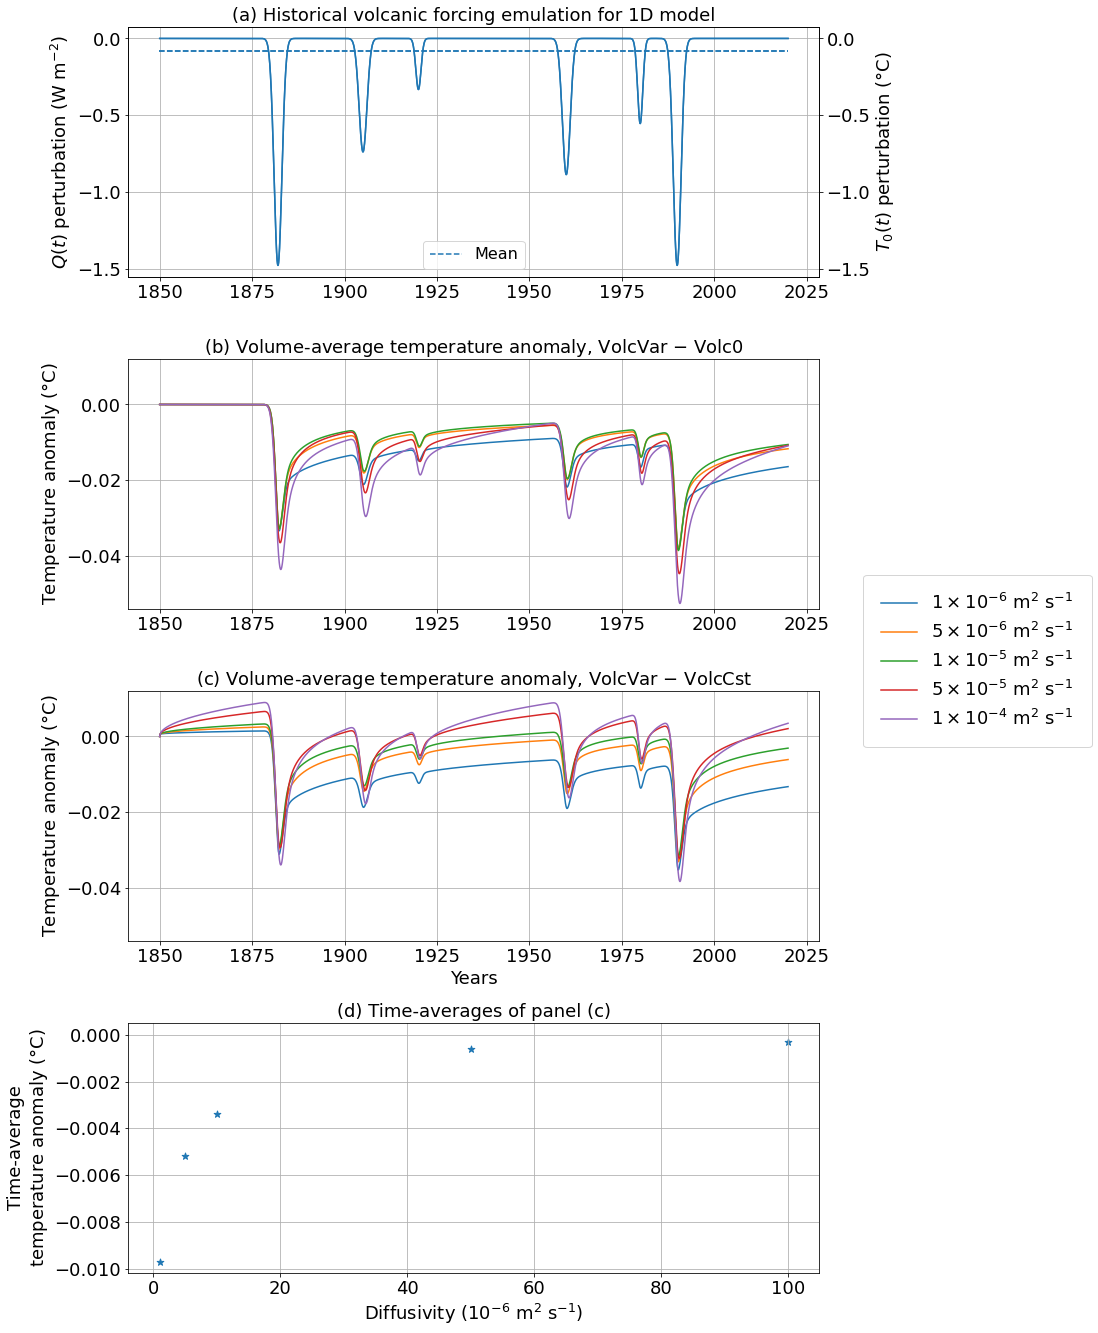

In [31]:
fig = plt.figure(figsize=(12,20))

fontsize=18

ax = fig.add_subplot(4, 1, 1)
ax.plot(1850 + t/360, T0_volc_var)
ax.axhline(y=np.mean(T0_volc_var), xmin=0.045, xmax=1-0.045, linestyle='--', label='Mean')
ax.set_xlabel('',fontsize=18)
ax.set_ylabel('$Q(t)$ perturbation (W m$^{-2})$',fontsize=fontsize)
# ax.set_title(r'(a) 5$\times$ historical volcanic forcing emulation for 1D model', fontsize=fontsize)
ax.set_title(r'(a) Historical volcanic forcing emulation for 1D model', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.grid()
ax.legend(loc='lower center', fontsize=16)
# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
ax2.plot(1850 + t/360, T0_volc_var)
ax2.axhline(y=np.mean(T0_volc_var), xmin=0.045, xmax=1-0.045, linestyle='--', label='Mean')
ax2.set_xlabel('',fontsize=fontsize)
ax2.set_ylabel('$T_0(t)$ perturbation ($\degree$C)',fontsize=fontsize)
ax2.set_title('', fontsize=fontsize)
ax2.tick_params(labelsize=fontsize)

ymax = 0.012
ymin = -0.054

# kappa_labels = [r'$1 \times 10^{{-6}}$ m$^2$ s$^{-1}$',
#                r'$2.5 \times 10^{{-6}}$ m$^2$ s$^{-1}$',
#                r'$5 \times 10^{{-6}}$ m$^2$ s$^{-1}$',
#                r'$7.5 \times 10^{{-6}}$ m$^2$ s$^{-1}$',
#                r'$1 \times 10^{{-5}}$ m$^2$ s$^{-1}$',
#                r'$2.5 \times 10^{{-5}}$ m$^2$ s$^{-1}$',
#                r'$5 \times 10^{{-5}}$ m$^2$ s$^{-1}$',
#                r'$1 \times 10^{{-4}}$ m$^2$ s$^{-1}$']

kappa_labels = [r'$1 \times 10^{{-6}}$ m$^2$ s$^{-1}$',
               r'$5 \times 10^{{-6}}$ m$^2$ s$^{-1}$',
               r'$1 \times 10^{{-5}}$ m$^2$ s$^{-1}$',
               r'$5 \times 10^{{-5}}$ m$^2$ s$^{-1}$',
                r'$1 \times 10^{{-4}}$ m$^2$ s$^{-1}$']

ax = fig.add_subplot(4, 1, 2)
for i in range(len(OHC_volc_var_cont_kappas)):
    OHC_volc_var_cont_kappas[i].plot(ax=ax)
    ax.set_title('(b) Volume-average temperature anomaly, VolcVar $-$ Volc0', fontsize=fontsize)
    ax.set_xlabel('', fontsize=fontsize)
    ax.set_ylabel('Temperature anomaly ($\degree$C)', fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.grid(visible=True)
    ax.set_ylim(ymin, ymax)

ax = fig.add_subplot(4, 1, 3)
for i in range(len(OHC_volc_var_cst_kappas)):
    OHC_volc_var_cst_kappas[i].plot(ax=ax, label=kappa_labels[i])
    ax.set_title('(c) Volume-average temperature anomaly, VolcVar $-$ VolcCst', fontsize=fontsize)
    ax.set_xlabel('Years', fontsize=fontsize)
    ax.set_ylabel('Temperature anomaly ($\degree$C)', fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.grid(visible=True)
    ax.set_ylim(ymin, ymax)
    # ax.legend(fontsize=14, ncol=2, loc='lower center')
    ax.legend(fancybox=True, borderpad=1,bbox_to_anchor=(1.05, 1.12),loc = 'center left', fontsize=fontsize)
    
ax = fig.add_subplot(4, 1, 4)
OHC_volc_var_averages = np.array([OHC_volc_var_cst_kappas[i].mean(dim='time') for i in range(len(OHC_volc_var_cst_kappas))])# * 1.3e18 * 4000 * 1035 * 2
ax.scatter(kappas/1e-6, OHC_volc_var_averages, s=50, marker='*', color='C0')
ax.grid()
ax.set_ylabel('Time-average\ntemperature anomaly ($\degree$C)', multialignment='center', fontsize=fontsize)
ax.set_xlabel(r'Diffusivity ($10^{-6}$ m$^2$ s$^{-1}$)', fontsize=fontsize)
ax.set_title('(d) Time-averages of panel (c)', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_ylim(None, 0.0005)
    
plt.subplots_adjust(left=0.1,
                    bottom=None, 
                    right=0.9, 
                    top=0.99, 
                    wspace=None, 
                    hspace=0.33)

# plt.savefig('Fig13.pdf', bbox_inches='tight', dpi=300)

In [58]:
np.array([OHC_volc_var_cst_kappas[i].mean(dim='time') for i in range(len(kappas))]), np.array([OHC_volc_var_cont_kappas[i].mean(dim='time') for i in range(len(kappas))])

(array([-0.00970909, -0.00518772, -0.00337407, -0.0005938 , -0.00030303]),
 array([-0.01216027, -0.00916538, -0.00858905, -0.0103824 , -0.01224203]))

In [60]:
0.00970909 / 0.01216027

0.7984271730808609

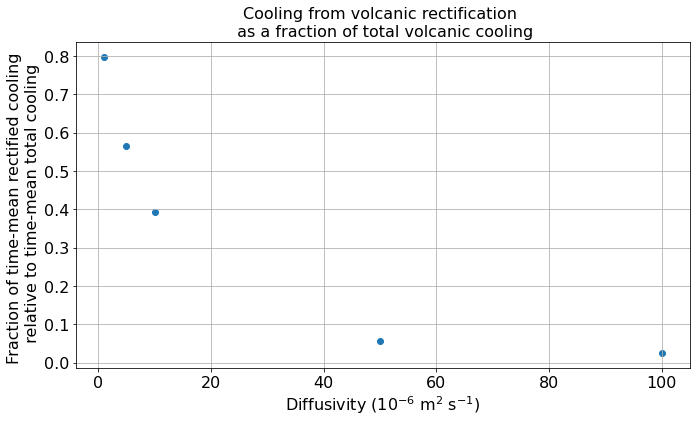

In [56]:
plt.figure(figsize=(11,6))

plt.scatter(kappas / 1e-6, np.array([OHC_volc_var_cst_kappas[i].mean(dim='time') for i in range(len(OHC_volc_var_cst_kappas))]) \
         / np.array([OHC_volc_var_cont_kappas[i].mean(dim='time') for i in range(len(OHC_volc_var_cst_kappas))]))
plt.grid()

fontsize=16
plt.title('Cooling from volcanic rectification \n as a fraction of total volcanic cooling', fontsize=fontsize)
plt.ylabel('Fraction of time-mean rectified cooling \n relative to time-mean total cooling', fontsize=fontsize)
plt.xlabel(r'Diffusivity ($10^{-6}$ m$^2$ s$^{-1}$)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()

In [5]:
0.2*2 * 0.005 * 1035*3992*1.38e18

# *0.2 since we do 5x volcanic forcing; *2 since ACCESS-OM2 responses were always at least twice as large as 1D

### Historical uptake from 1871 estimated to be ~470 ZJ (Zanna+ 2017)

1.1403547199999998e+22